# cosmology package comparison: astropy vs colossus

since `astropy.cosmology` is not complete, I usually use `colussus` for cosmology calculations. Here is a basic reference of how to use `colossus`.

We compare `astropy.cosmoloy` ('ascosmo') and `colossus` ('cosmo') for the following cosmological calculations:

In [19]:
from scipy.misc import derivative
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

In [20]:
from astropy.cosmology import Planck15 as ascosmo
import astropy.units as u
from colossus.cosmology import cosmology

In [21]:
# cosmo = cosmology.setCosmology('planck15')
params = {
    'flat': True,
    'H0': 67.742,  # Hubble 参数
    'Om0': 0.3099,  # 物质密度参数
    'Ob0': 0.0486,  # 重子密度参数（可选）
    'sigma8': 0.808992,  # sigma8 参数
    'ns': 0.96822  # 标量谱指数
}

cosmo = cosmology.setCosmology('myCosmo', params)

the parameters names are same.

In [22]:
h = cosmo.h
H0 = cosmo.H0 
OmM, OmL = cosmo.Om0, cosmo.Ode0
h, H0, OmM, OmL, OmM+OmL

(0.67742, 67.742, 0.3099, 0.6900088346286786, 0.9999088346286786)

In [23]:
ascosmo.H0

<Quantity 67.74 km / (Mpc s)>

`colussus` use unit Mpc/h, while `astropy.cosmology` use Mpc and calculate with units. 
we prepare unit Mpc/h for `colussus` here:

In [24]:
Mpc_per_h = u.def_unit('Mpc/h', u.Mpc / h)
(1*u.Mpc).to(Mpc_per_h)

<Quantity 0.67742 Mpc/h>

## H(z)

In [25]:
z=1.2
cosmo.Hz(z)*u.km/u.s/u.Mpc

<Quantity 135.34776396 km / (Mpc s)>

In [26]:
ascosmo.H(z)

<Quantity 135.17733731 km / (Mpc s)>

## comoving distance

In [27]:
ascosmo.comoving_distance(z)

<Quantity 3865.80714198 Mpc>

In [28]:
d = cosmo.comovingDistance(0, z) * Mpc_per_h 
print(d, d.to(u.Mpc))

2616.9666989671136 Mpc/h 3863.137638344179 Mpc


## time

In [29]:
cosmo.lookbackTime(1)


array(7.93080889)

In [30]:
ascosmo.lookback_time(1), ascosmo.lookback_time(4), ascosmo.lookback_time(1100)

(<Quantity 7.93506664 Gyr>,
 <Quantity 12.25651027 Gyr>,
 <Quantity 13.79724884 Gyr>)

In [31]:
ascosmo.lookback_time(11000)-ascosmo.lookback_time(1)
ascosmo.lookback_time(11000)-ascosmo.lookback_time(4)

<Quantity 1.54109993 Gyr>

## colussus-only

### growth factor

In [32]:
def GrowthRate(z):
    a = 1/(1+z)
    
    def D(a):
        z = 1/a - 1
        return cosmo.growthFactor(z) 
    
    def logarithmic_derivative(a):
        # 使用 scipy 的 derivative 函数来计算导数
        dD_da = derivative(D, a, dx=1e-6)
        # 计算对数导数
        dlnD_dlna = dD_da * a / D(a)
        return dlnD_dlna    
    
    return logarithmic_derivative(a)

def f(z):
    return GrowthRate(z)


### linear power spectrum

In [33]:
ks = np.logspace(-4, 1, 100)
pks_mz = cosmo.matterPowerSpectrum(ks, z)
pks_m0 = cosmo.matterPowerSpectrum(ks, 0)

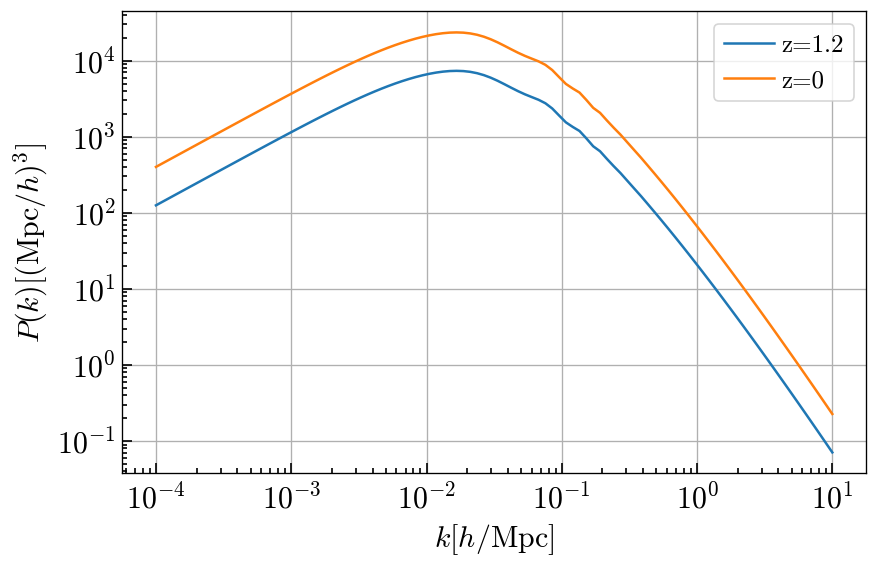

In [34]:
plt.plot(ks, pks_mz, label=f'z={z}')
plt.plot(ks, pks_m0, label=f'z=0')
plt.xlabel(r'$k [h/{\rm Mpc}]$')
plt.xscale('log')
plt.ylabel(r'$P(k) [({\rm Mpc}/h)^3]$')
plt.yscale('log')
plt.legend()

In [35]:
np.savetxt("../data/pkl_z0.dat", np.column_stack((ks, pks_m0)))